### Import the libraries

In [1]:
'''
Description: It is a python program to solve the New York Taxi Fare Prediction Problem
Author: Zhizhou Qiu
Date: April 18
'''

In [ ]:
import datetime as dt
import os
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Load dataset

In [2]:
train_df = pd.read_csv('train.csv', nrows=8000000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Data Exploration

In [3]:
print(train_df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    49
dropoff_latitude     49
passenger_count       0
dtype: int64


Since some of the rows are `NaN`'s, we need to remove these rows first.

In [4]:
train_df.dropna(how='any', axis='rows', inplace=True)

In [5]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
import matplotlib.pyplot as plt

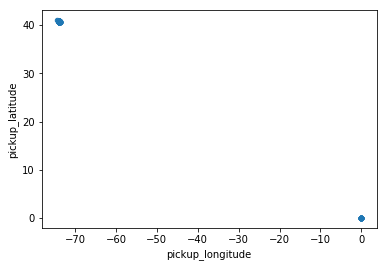

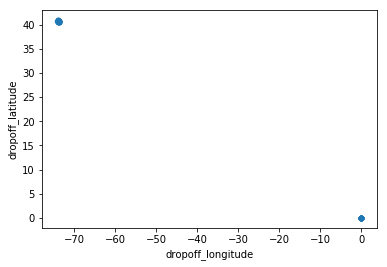

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,7.999951e+06,7.999951e+06,7.999951e+06,7.999951e+06,7.999951e+06,7.999951e+06
mean,1.133909e+01,-7.251306e+01,3.992343e+01,-7.251237e+01,3.992143e+01,1.684731e+00
std,9.807115e+00,1.289840e+01,9.122781e+00,1.285973e+01,9.311601e+00,1.324927e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076711e+01,-7.396368e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


In [7]:
# Plot variables using only 1000 rows for efficiency
train_df.iloc[:1000].plot.scatter('pickup_longitude', 'pickup_latitude')
train_df.iloc[:1000].plot.scatter('dropoff_longitude', 'dropoff_latitude')
plt.show()
# Get distribution of values
train_df.describe()

Okay, that was interesting. We learned a few things about the dataset:
* Fare_amount has negative values. We will remove these.
* Latitudes and longitudes have values far away from (40, -74) that can't be correct since NYC is at (40, -74) aprox. We will remove points not near these coordinates.
* Passenger_count has values of 0 and as high as 200, which are also unrealistic. We will remove those.

In [8]:
print(train_df[train_df.passenger_count > 6].shape)

(14, 8)


In [9]:
# Clean dataset
def clean_df(df):
    return df[(df.fare_amount > 0) &
             (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
             (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
             (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
             (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) &
             (df.passenger_count > 0) & (df.passenger_count < 10)]

print('Old size: %d' % len(train_df))
train_df = clean_df(train_df)
print('New size: %d' % len(train_df))

Old size: 7999951
New size: 7805793


### Feature engineering

Add some interesting features in the dataset:
* total_distance: distance from pickup to dropoff. The longer the trip, the more expensive.
* Extract information from datetime( day of week, month, hour, day). Taxi fares change day/ night or on weekdays/ holidays.

In [10]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates
    """
    # Define earth radius (km)
    R_earth = 6371
    # Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians, 
                                                           [pickup_lat, pickup_lon, 
                                                            dropoff_lat, dropoff_lon])
    # Compute distance along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    # Compute haversine distance
    a = np.sin(dlat / 2.0) ** 2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon / 2.0) ** 2
    return 2 * R_earth * np.arcsin(np.sqrt(a))
    

def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

In [11]:
train_df = add_datetime_info(train_df)
train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])

train_df.head()    

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,1.999157


Now we will drop the columns that we will not use to train our model.
* key
* pickup_datetime

In [12]:
train_df.drop(columns=['key', 'pickup_datetime'], inplace=True)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,1.999157


### Model training

Now that we have the dataframe that we wanted we can start to train the XGBoost model. First we will split the dataset into train(99%) and test(1%). With this amount of data 1% should be enough to test performance.

In [13]:
y = train_df['fare_amount']
train = train_df.drop(columns=['fare_amount'])

x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=0, test_size=0.01)

In [14]:
%%time
XGB_model = XGBRegressor(learning_rate=0.3, max_depth=6, n_jobs=-1, silent=False)
XGB_model.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


CPU times: user 54min 23s, sys: 15.1 s, total: 54min 38s
Wall time: 54min 54s


In [15]:
%%time
y_XGB_predict = XGB_model.predict(x_test)

XGB_model_error = np.sqrt(mean_squared_error(y_test, y_XGB_predict))

print(f'XGBoost Root Mean Squared Error - {XGB_model_error}')

XGBoost Root Mean Squared Error - 3.7931475153063303
CPU times: user 376 ms, sys: 31.8 ms, total: 408 ms
Wall time: 437 ms


### Prediction

Finally we can use our trained model to predict the submission. First we will need to load and preprocess the test dataset just like we did for the training dataset.

In [16]:
# Read and preprocess test set
test_df = pd.read_csv('test.csv')
test_df = add_datetime_info(test_df)
test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_key = test_df['key']
x_pred = test_df.drop(columns=['key', 'pickup_datetime'])

#Predict from test set
prediction = XGB_model.predict(x_pred)

In [17]:
#Create submission file
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction.round(2)
})
submission = submission[['key', 'fare_amount']]
submission.to_csv('taxi_fare_submission.csv',index=False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.13
1,2015-01-27 13:08:24.0000003,10.94
2,2011-10-08 11:53:44.0000002,4.90
3,2012-12-01 21:12:12.0000002,9.21
4,2012-12-01 21:12:12.0000003,15.68
